In [1]:
# Import libraries. 
# Generate images in the notebook
%matplotlib inline

import matplotlib.pyplot as plt
import collections
from collections import defaultdict
import gzip
import itertools
import numpy as np
import os
import time
import pandas as pd
import seaborn as sns

import bokeh
import bokeh.io
from bokeh.io import push_notebook
from bokeh.plotting import figure, show, save, output_notebook, output_file

# Import colour palettes for later on
from bokeh.palettes import Category20b
from bokeh.palettes import Purples
from bokeh.palettes import Greens
from bokeh.palettes import YlOrBr
from bokeh.palettes import YlOrRd
from bokeh.palettes import PuOr
from bokeh.palettes import RdGy

# Dimension reduction tools
from sklearn.decomposition import PCA as PCA
from sklearn.manifold import TSNE
import umap 

In [2]:
#loading population data
population_key= pd.read_csv("sample_key.txt", sep='\t', header=None)
#population_key.set_index()

#changing the first row to headers
headers = population_key.iloc[0]
population_key_df  = pd.DataFrame(population_key.values[1:], columns=headers) 

print(population_key_df['CLUSTER'].unique())

cluster_names=population_key_df['CLUSTER'].unique()
cluster_names_sorted=population_key_df['CLUSTER'].value_counts().index.tolist()


['Picard' 'West_Grande_Terre' 'Mauritius' 'Bern_Zoo' 'East_Grande_Terre'
 'South_Grande_Terre' 'Rodrigues' 'Ile_Lanier' 'Ile_Michel' 'Ile_Esprit'
 'East_Malabar' 'West_Malabar' 'Zurich_Zoo']


In [3]:
#print(population_key_df.head(3))

#print(population_key_df.sort_values(by='CLUSTER',ascending=True))
print(population_key_df['CLUSTER'].value_counts().index.tolist())



#aa=population_key_df.sort_values(by='CLUSTER')







['Mauritius', 'East_Grande_Terre', 'Picard', 'South_Grande_Terre', 'East_Malabar', 'West_Grande_Terre', 'Ile_Michel', 'West_Malabar', 'Rodrigues', 'Ile_Lanier', 'Ile_Esprit', 'Bern_Zoo', 'Zurich_Zoo']


In [4]:
print(population_key_df.loc[population_key_df['CLUSTER'] == cluster_names_sorted[1]])

0    FID    IID            CLUSTER
22    23   CC01  East_Grande_Terre
23    24   CC02  East_Grande_Terre
24    25   CC03  East_Grande_Terre
25    26   CC06  East_Grande_Terre
26    27   CC14  East_Grande_Terre
27    28   CC16  East_Grande_Terre
28    29   CC21  East_Grande_Terre
29    30   CC22  East_Grande_Terre
30    31   CC25  East_Grande_Terre
31    32   CC26  East_Grande_Terre
32    33   CC27  East_Grande_Terre
33    34   CC31  East_Grande_Terre
34    35   CC32  East_Grande_Terre
35    36   CC33  East_Grande_Terre
36    37   CC36  East_Grande_Terre
37    38   CC41  East_Grande_Terre
69    70  GTE01  East_Grande_Terre
70    71  GTE02  East_Grande_Terre
71    72  GTE03  East_Grande_Terre
72    73  GTE04  East_Grande_Terre
73    74  GTE05  East_Grande_Terre
130  131   TK05  East_Grande_Terre
131  132   TK06  East_Grande_Terre
133  134   TK11  East_Grande_Terre
134  135   TK12  East_Grande_Terre


In [5]:
#generate a dictionary that contains clusters to check and IDs in it
#df is the dataframe version and np is numpy array, will continue with np

struct_np=dict() #initiate an empty dictionary
Order_df=pd.DataFrame()
print(Order_df)

for i in range(0,len(cluster_names)):
       Order_df= Order_df.append(population_key_df.loc[population_key_df['CLUSTER'] == cluster_names_sorted[i]])

print(Order_df)


Empty DataFrame
Columns: []
Index: []
0    FID       IID     CLUSTER
7      8     ANA01   Mauritius
8      9     ANA02   Mauritius
20    21     CAS01   Mauritius
21    22     CAS08   Mauritius
41    42     COL01   Mauritius
..   ...       ...         ...
79    80  ILELAN03  Ile_Lanier
89    90   ILESP01  Ile_Esprit
90    91   ILESP02  Ile_Esprit
19    20      BERN    Bern_Zoo
142  143      ZOO1  Zurich_Zoo

[143 rows x 3 columns]


/var/folders/5c/dpc69bms35s7wc11y9mrgd7h001r18/T/ipykernel_74667/3048536830.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Order_df= Order_df.append(population_key_df.loc[population_key_df['CLUSTER'] == cluster_names_sorted[i]])
/var/folders/5c/dpc69bms35s7wc11y9mrgd7h001r18/T/ipykernel_74667/3048536830.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Order_df= Order_df.append(population_key_df.loc[population_key_df['CLUSTER'] == cluster_names_sorted[i]])
/var/folders/5c/dpc69bms35s7wc11y9mrgd7h001r18/T/ipykernel_74667/3048536830.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Order_df= Order_df.append(population_key_df.loc[population_key_df['CLUSTER'] == cluster_names_sorted[i]])
/var/folders/5c/dpc69bms35s7wc1

In [6]:
#loading relatedness data and correcting the idx so that there wont be 0 and it will match the individual samples' id
relatedness= pd.read_csv("deneme_rm1_20_m05.txt", sep='\t') # load relatedness data
relatedness['a']=relatedness['a']+1 # correct the IDs so that they will match the ones in the dictionaries as combinations
relatedness['b']=relatedness['b']+1 # same as above, this time for the b column.
print(relatedness.head(2))

   a  b  ida  idb   nSites        J9        J8        J7        J6        J5  \
0  1  2  ACP  AGO  4398322  0.449125  0.281608  0.057019  0.055365  0.013619   
1  1  3  ACP  AHC  4329358  0.422116  0.324969  0.023196  0.024080  0.062928   

   ...         loglh  nIter  bestoptimll  coverage  \
0  ... -5.831279e+06    178         -1.0  0.593536   
1  ... -5.641914e+06    178         -1.0  0.584229   

                                               2dsfs        R0        R1  \
0  4.297776e-01,1.356807e-01,2.965957e-02,1.29289...  0.507865  0.308364   
1  4.353710e-01,1.364934e-01,2.287467e-02,1.34146...  0.461462  0.286587   

       KING  2dsfs_loglike  2dsfsf_niter  
0 -0.003322  -6.275533e+06            30  
1  0.015330  -6.076937e+06            30  

[2 rows x 35 columns]


In [ ]:
#print(relatedness.iloc[0,14])
#print(int(relatedness.iloc[1,0]),int(relatedness.iloc[1,1]))
i=1
j=0
#print(relatedness.iloc[:,0])

#print(np.where((relatedness.iloc[:,0] == int(i)) & (relatedness[:,1] == int(j))))
#print(relatedness.loc[(relatedness['a']==i+1) & (relatedness['b']==j+1)]['rab'][0])



In [ ]:
#initiate a relatedness matrix

relatedness_matrix=np.zeros((Order_df.shape[0],Order_df.shape[0])) # generate an empty matrix with zeros
#sns.heatmap(relatedness_matrix)

i=1
j=7
a=(relatedness.loc[(relatedness['a']==i) & (relatedness['b']==j)]['rab'].to_numpy())

print(a)
#print(relatedness.loc[(relatedness['a']==i) & (relatedness['b']==j)]['rab'][0])




In [7]:
#order'i duzeltmek lazim onun icin i'yi ORder_DF teki FID olarak almak lazim.
#i=0 ORder FID 0da ne yaziyosa mesela 8 ona esit olacak.
relatedness_matrix=np.zeros((Order_df.shape[0],Order_df.shape[0])) # generate an empty matrix with zeros
for i in range(0,Order_df.shape[0]):
    #print('i:'+str(i))
    for j in range(0,Order_df.shape[0]):
        #print('j:'+str(j))
        if i <= j:
            if i == j:
                relatedness_matrix[i,j]=np.nan
            else:
                relatedness_matrix[i,j]=relatedness.loc[(relatedness['a']==i+1) & (relatedness['b']==j+1)]['rab'].to_numpy()
                relatedness_matrix[j,i]=relatedness.loc[(relatedness['a']==i+1) & (relatedness['b']==j+1)]['rab'].to_numpy()




In [39]:
ordered_ids=Order_df['FID'].to_numpy()
print(ordered_ids)

['8' '9' '21' '22' '42' '43' '76' '77' '93' '94' '96' '97' '98' '99' '100'
 '101' '118' '119' '120' '121' '122' '123' '124' '126' '127' '23' '24'
 '25' '26' '27' '28' '29' '30' '31' '32' '33' '34' '35' '36' '37' '38'
 '70' '71' '72' '73' '74' '131' '132' '134' '135' '1' '2' '3' '17' '18'
 '19' '39' '40' '41' '44' '45' '52' '63' '64' '75' '92' '95' '125' '46'
 '47' '48' '49' '50' '51' '53' '54' '55' '56' '57' '58' '59' '60' '61'
 '62' '102' '103' '104' '105' '106' '107' '108' '109' '110' '111' '112'
 '113' '114' '115' '116' '117' '4' '5' '6' '7' '10' '11' '12' '13' '14'
 '15' '16' '128' '129' '130' '133' '81' '82' '83' '84' '85' '86' '87' '88'
 '89' '136' '137' '138' '139' '140' '141' '142' '65' '66' '67' '68' '69'
 '78' '79' '80' '90' '91' '20' '143']


In [38]:
i=3
j=4
print(ordered_ids[i])
print(ordered_ids[j])

print(relatedness_matrix[i,j])
print(relatedness_matrix[int(ordered_ids[i])-1,int(ordered_ids[j])-1])

#print(ordered_ids.dtype)

#print(relatedness_matrix()

22
42
0.073078
0.049297


In [40]:

relatedness_matrix_sorted=np.zeros((Order_df.shape[0],Order_df.shape[0])) # generate an empty matrix with zeros

for i in range(0,Order_df.shape[0]):
    for j in range(0,Order_df.shape[0]):
        if i <= j:
            if i == j:
                relatedness_matrix_sorted[i,j]=np.nan
            else:
                relatedness_matrix_sorted[i,j]=relatedness_matrix[int(ordered_ids[i])-1,int(ordered_ids[j])-1]
                relatedness_matrix_sorted[j,i]=relatedness_matrix[int(ordered_ids[i])-1,int(ordered_ids[j])-1]



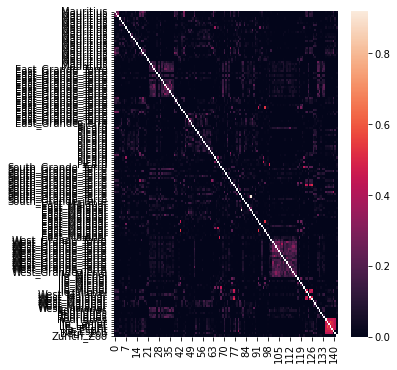

In [47]:
plt.figure(figsize=(5,6))
sns.heatmap(relatedness_matrix,yticklabels=Order_df['CLUSTER'])


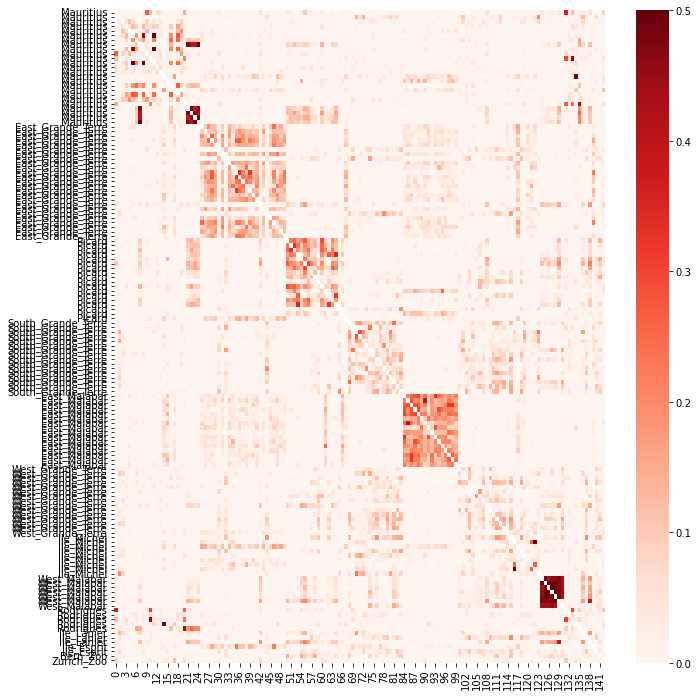

In [48]:
plt.figure(figsize=(11,12))
sns.heatmap(relatedness_matrix_sorted,yticklabels=Order_df['CLUSTER'],cmap='Reds',vmin=0, vmax=0.5)
plt.savefig('Relatedness_Heatmap_sortedbyclust.png',format='png',dpi=100,transparent = False,facecolor='white')

